In [1]:
from typing import List, Union
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from collections import Counter
from sklearn import model_selection, linear_model, svm, naive_bayes
import itertools

sns.set_style("darkgrid")

Import data

In [2]:
train_df = pd.read_csv("./data/train.csv")
submit_df = pd.read_csv("./data/test.csv")

## Data exploration

In [3]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can also extract passenger titles from names such as Mr., Miss, etc.

In [4]:
def get_titles(series: pd.Series) -> pd.Series:
    return (train_df['Name']
            .str.split(',').apply(lambda x: x[1])
            .str.split('.').apply(lambda x: x[0]))


train_df['Title'] = get_titles(train_df['Name'])

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Key insights:
1. The dataset is quite small having only 891 entries
1. Baseline for the model: Predict that none passangers survived and it will yield accuracy of 42%, since we see that only 38% of passengers survived
1. Not all entries contain ages of passengers
1. On average 1 in 2 passengers had a sibling or spouse on board and 1 in 3 have a family member (blood related)

In [6]:
train_df.isna().sum().to_frame().T

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,0,0,0,0,0,177,0,0,0,0,687,2,0


Missing alot of cabain numbers, but such information is most likeley not useful for prediction anyways, as we have better variables that suggest about the cabains location or quality - Fare and Ticket class.

Age on the other hand might be a crucial feature, based on the rule "Childern and Women first". We should try some solutions for it. Removing missing data does not seem good as it accounts for 20% of training data. I will try to populate with average value and create a predictor

As for Embarked, only 2 missing data points, we can easily remove or assign the mode value, as i fail to see that this could be a crucial feature for predictions

In [7]:
Counter(train_df['Embarked'])

Counter({'S': 644, 'C': 168, 'Q': 77, nan: 2})

In [8]:
Counter(train_df['Sex'])

Counter({'male': 577, 'female': 314})

In [9]:
train_df[train_df['Title'] == 'y']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [10]:
Counter(train_df['Title'])

Counter({' Mr': 517,
         ' Mrs': 125,
         ' Miss': 182,
         ' Master': 40,
         ' Don': 1,
         ' Rev': 6,
         ' Dr': 7,
         ' Mme': 1,
         ' Ms': 1,
         ' Major': 2,
         ' Lady': 1,
         ' Sir': 1,
         ' Mlle': 2,
         ' Col': 2,
         ' Capt': 1,
         ' the Countess': 1,
         ' Jonkheer': 1})

After a bit of googling it seems that all of the titles are correct, just based on different origins

Lets first observe if some features are alone good predictors

In [11]:
train_df.pivot_table(columns='Survived')

Survived,0,1
Age,30.626179,28.343690
Fare,22.117887,48.395408
Parch,0.329690,0.464912
PassengerId,447.016393,444.368421
Pclass,2.531876,1.950292
SibSp,0.553734,0.473684


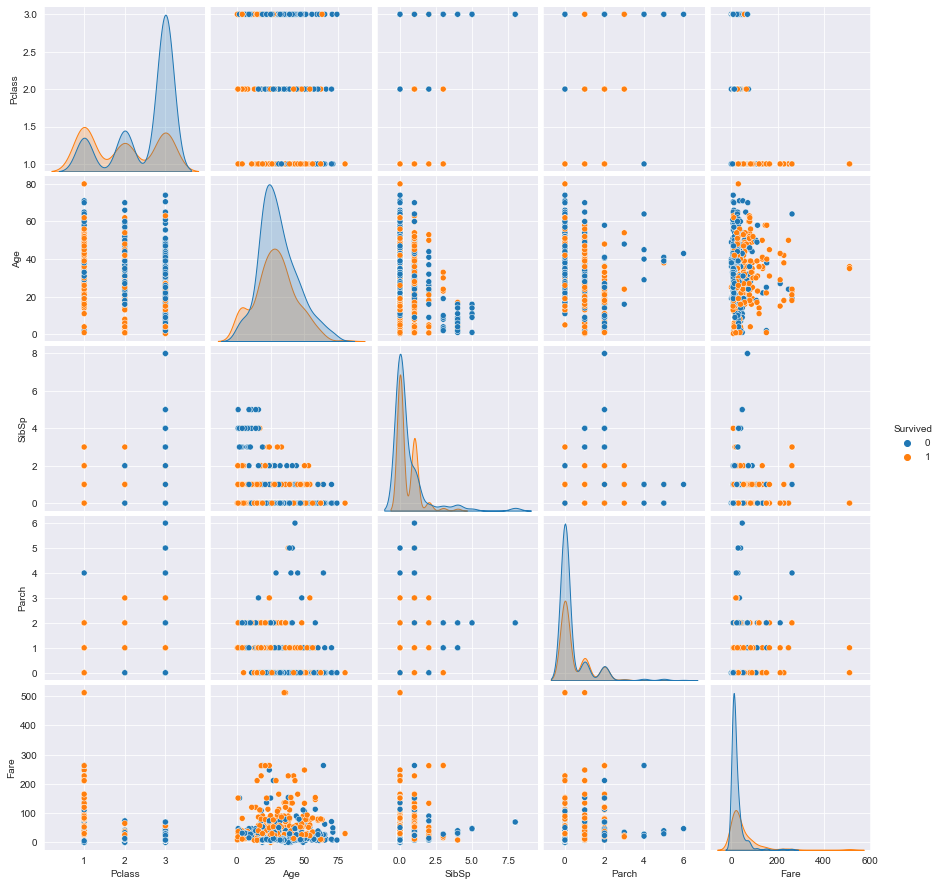

In [12]:
sns.pairplot(train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']],
             hue="Survived")

1. People who paid most and had the highest class tickets, were most likely to survive
1. Passengers with more reletives were more likely to not survive, however the pairplot also shows that this is a causation not correlation, as more reletives ~ lower class and cheaper tickets

<AxesSubplot:xlabel='Age', ylabel='Count'>

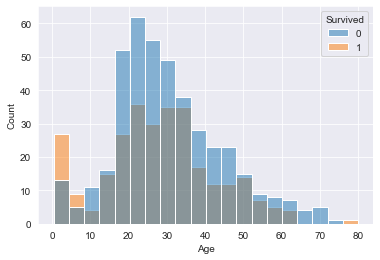

In [13]:
sns.histplot(data=train_df, x='Age', hue="Survived")

<AxesSubplot:xlabel='Sex', ylabel='Count'>

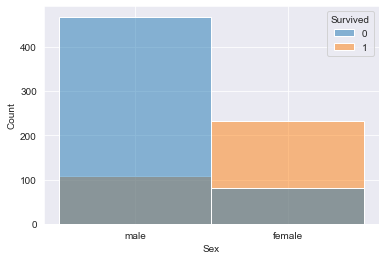

In [14]:
sns.histplot(data=train_df, x='Sex', hue="Survived")

<AxesSubplot:xlabel='Title', ylabel='Count'>

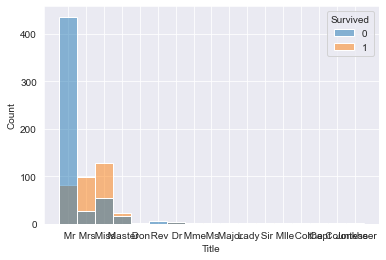

In [15]:
sns.histplot(data=train_df, x='Title', hue="Survived")

The Histograms agree with the common saying "Children and women first" when trying to save people from disasters

## Data cleaning

Need to:
1. Remove cabain, name, ticket columns, set passenger id as index
1. Fill in missing data for Age and Embark
1. Standardize data as we will most likely want to use regularization and SVMs (Age, Fare)
(Both seem to have a gaussian distribution, with Fare having a bit more extreme values)

Categorical values will be one hot encoded in the end

In [16]:
clean_df = train_df.copy()

In [17]:
clean_df = clean_df.drop(['Name', 'Cabin', 'Ticket'], axis=1)
clean_df = clean_df.set_index('PassengerId')

In [18]:
mu_age, std_age = clean_df['Age'].mean(), clean_df['Age'].std()
mu_fare, std_fare = clean_df['Fare'].mean(), clean_df['Fare'].std()

mode_embark = clean_df['Embarked'].mode()[0]

clean_df['Embarked'] = clean_df['Embarked'].fillna(mode_embark)
# Keep values saved as they need to be used for test and prediction data

In [19]:
def one_hot_encode(
    df: pd.DataFrame, columns: List[str] = ['Pclass', 'Sex', 'Embarked', 'Title']
) -> pd.DataFrame:
    return pd.get_dummies(df, columns=columns)

In [20]:
clean_df_one_hot = one_hot_encode(clean_df)
cols_order = clean_df_one_hot.columns  # retain columns ordering
clean_df_no_nan = clean_df_one_hot.dropna()
clean_df_missing_age = clean_df_one_hot[clean_df_one_hot['Age'].isna()].drop(
    'Age', axis=1)


linear_model_age = linear_model.LinearRegression()

linear_model_age.fit(X=clean_df_no_nan.drop('Age', axis=1),
                     y=clean_df_no_nan['Age'])

predicted_age = linear_model_age.predict(clean_df_missing_age)

In [21]:
def overwrite_missing_age(
    missing_age_df: pd.DataFrame, series_or_vlaue: Union[pd.Series, float], col_order: List[str]
) -> pd.DataFrame:

    return_df = missing_age_df.copy()
    return_df['Age'] = series_or_vlaue
    return return_df[col_order]

In [22]:
clean_df_mean_age = overwrite_missing_age(
    clean_df_missing_age, mu_age, cols_order)

clean_df_impute_age = overwrite_missing_age(
    clean_df_missing_age, predicted_age, cols_order)

df_mean_age = pd.concat([clean_df_no_nan, clean_df_mean_age])
df_impute_age = pd.concat([clean_df_no_nan, clean_df_impute_age])

In [23]:
def standardize_series(series: pd.Series, mu, std) -> pd.Series:
    return (series - mu) / std

In [24]:
df_mean_age['Age'] = standardize_series(df_mean_age['Age'], mu_age, std_age)
df_mean_age['Fare'] = standardize_series(
    df_mean_age['Fare'], mu_fare, std_fare)

In [25]:
df_impute_age['Age'] = standardize_series(
    df_impute_age['Age'], mu_age, std_age)
df_impute_age['Fare'] = standardize_series(
    df_impute_age['Fare'], mu_fare, std_fare)

## Predictions

In [26]:
train_df, test_df = model_selection.train_test_split(
    df_mean_age, test_size=0.2)
# Lets keep the split rows same in both mean age df and imputed age df
train_df_imp = df_impute_age.loc[df_impute_age.index.isin(train_df.index)]
test_df_imp = df_impute_age.loc[df_impute_age.index.isin(test_df.index)]

We want to classify if a person would have died or not in the titanic disaster.

It is a two class classification problem, so appropriate models would be:
1. Logistic regression
1. SVM machine
1. Naive Bayes
1. Decision tree / forest
1. Neural network (Why not)

### Logistic regression

In [27]:
Cs = np.arange(0.1, 10.1, 0.1)
reg_ratios = np.linspace(0.1, 1, 10)

log_model_l1 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l1', solver='liblinear')
log_model_l2 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l2', solver='liblinear')
log_model_elastic = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='elasticnet', solver='saga', l1_ratios=reg_ratios, max_iter=500)

In [28]:
log_model_l1.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
print("log_model_l1 trained")
log_model_l2.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
print("log_model_l2 trained")
log_model_elastic.fit(train_df.drop('Survived', axis=1), train_df['Survived'])
print("log_model_elastic trained")

log_model_l1 trained
log_model_l2 trained
log_model_elastic trained


In [29]:
def model_evaluation(model, train_df, test_df):
    train_acc = model.score(train_df.drop(
        'Survived', axis=1), train_df['Survived'])
    test_acc = model.score(test_df.drop(
        'Survived', axis=1), test_df['Survived'])

    x_df = pd.DataFrame((model.feature_names_in_, model.coef_[0])).T
    x_df.columns = ['name', 'coef']
    top_10_features = x_df.sort_values(
        'coef', key=abs, ascending=False).head(10)

    print(f"""
    -----------------------------------------------------
    Parameters:
        C: {model.C_}
        l1 ratio: {model.l1_ratio_}
    
    Intercept: {model.intercept_}
    Top 10 coeficients: 
    {top_10_features.to_string(index=False,header=False)}
    
    Train / Test accuracy 
    {round(train_acc*100,2)}% / {round(test_acc*100,2)}%
    -----------------------------------------------------
    
    """)

In [30]:
print('Log model with Lasso regularization')
model_evaluation(log_model_l1, train_df, test_df)
print('Log model with Ridge regularization')
model_evaluation(log_model_l2, train_df, test_df)
print('Log model with Elastic regularization')
model_evaluation(log_model_elastic, train_df, test_df)

Log model with Lasso regularization

    -----------------------------------------------------
    Parameters:
        C: [0.6]
        l1 ratio: [None]
    
    Intercept: [0.]
    Top 10 coeficients: 
    Title_ Master  2.390932
   Sex_female  1.526693
     Pclass_1  1.037052
     Pclass_3 -0.971616
   Title_ Mrs  0.860149
     Sex_male -0.658124
    Title_ Mr -0.570683
        SibSp -0.505884
          Age -0.360798
   Embarked_C  0.259358
    
    Train / Test accuracy 
    82.44% / 82.68%
    -----------------------------------------------------
    
    
Log model with Ridge regularization

    -----------------------------------------------------
    Parameters:
        C: [1.3]
        l1 ratio: [None]
    
    Intercept: [0.39136744]
    Top 10 coeficients: 
    Title_ Master  2.108169
   Sex_female  1.233471
     Pclass_1    1.1742
   Title_ Rev -0.932491
    Title_ Mr  -0.92759
     Pclass_3 -0.896314
     Sex_male -0.842103
   Title_ Mrs  0.808611
   Title_ Don  -0.67932
  

We get between 81-83% accuracy on test data with small difference between regularization models.

We also see that Sex, tittle and class were amongst the most important features.

Can we get better results using imputed age instead of mean age ?

In [31]:
Cs = np.arange(0.1, 10.1, 0.1)
reg_ratios = np.linspace(0.1, 1, 10)

log_model_l1 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l1', solver='liblinear')
log_model_l2 = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='l2', solver='liblinear')
log_model_elastic = linear_model.LogisticRegressionCV(
    Cs=Cs, penalty='elasticnet', solver='saga', l1_ratios=reg_ratios, max_iter=500)

In [32]:
log_model_l1.fit(train_df_imp.drop('Survived', axis=1),
                 train_df_imp['Survived'])
print("log_model_l1 trained")
log_model_l2.fit(train_df_imp.drop('Survived', axis=1),
                 train_df_imp['Survived'])
print("log_model_l2 trained")
log_model_elastic.fit(train_df_imp.drop(
    'Survived', axis=1), train_df_imp['Survived'])
print("log_model_elastic trained")

log_model_l1 trained
log_model_l2 trained
log_model_elastic trained


In [33]:
print('Log model with Lasso regularization')
model_evaluation(log_model_l1, train_df_imp, test_df_imp)
print('Log model with Ridge regularization')
model_evaluation(log_model_l2, train_df_imp, test_df_imp)
print('Log model with Elastic regularization')
model_evaluation(log_model_elastic, train_df_imp, test_df_imp)

Log model with Lasso regularization

    -----------------------------------------------------
    Parameters:
        C: [2.]
        l1 ratio: [None]
    
    Intercept: [0.]
    Top 10 coeficients: 
    Title_ Master  2.771832
   Sex_female  1.756673
     Pclass_1   1.33396
     Pclass_3 -1.089164
   Title_ Mrs  1.041114
   Title_ Rev -0.800384
     Sex_male  -0.73463
        SibSp  -0.60822
          Age -0.550924
   Title_ Sir  0.456889
    
    Train / Test accuracy 
    83.99% / 83.24%
    -----------------------------------------------------
    
    
Log model with Ridge regularization

    -----------------------------------------------------
    Parameters:
        C: [0.5]
        l1 ratio: [None]
    
    Intercept: [0.37741424]
    Top 10 coeficients: 
    Title_ Master  1.378466
     Pclass_1  1.208646
   Sex_female  1.053362
    Title_ Mr -0.998702
   Title_ Mrs  0.925097
     Pclass_3 -0.918137
     Sex_male -0.675948
          Age -0.554337
   Title_ Rev -0.526644
   

With imputed age dataframe we get up to 3% better results

### SVM machine

In [34]:
# SVM do not have built in way to determine best regularization param,
# So we do it ourselves

In [35]:
def train_svm(Cs, train_df):
    rbf_score = 0
    lin_score = 0

    for c in Cs:
        svc_rbf = svm.SVC(C=c, kernel='rbf')
        svc_lin = svm.SVC(C=c, kernel='linear')

        rbf_score_c = model_selection.cross_val_score(svc_rbf, train_df.drop(
            'Survived', axis=1), train_df['Survived'], cv=5, scoring='accuracy')
        lin_score_c = model_selection.cross_val_score(svc_lin, train_df.drop(
            'Survived', axis=1), train_df['Survived'], cv=5, scoring='accuracy')

        if rbf_score < rbf_score_c.mean():
            rbf_c = c
            rbf_score = rbf_score_c.mean()

        if lin_score < lin_score_c.mean():
            lin_c = c
            lin_score = lin_score_c.mean()

    svc_rbf = svm.SVC(C=rbf_c, kernel='rbf')
    svc_rbf.fit(train_df.drop('Survived', axis=1), train_df['Survived'])

    svc_lin = svm.SVC(C=lin_c, kernel='linear')
    svc_lin.fit(train_df.drop('Survived', axis=1), train_df['Survived'])

    return svc_rbf, svc_lin

In [36]:
def evaluate_svm(model, train_df, test_df):
    train_acc = model.score(train_df.drop(
        'Survived', axis=1), train_df['Survived'])
    test_acc = model.score(test_df.drop(
        'Survived', axis=1), test_df['Survived'])

    print(f"""
    -----------------------------------------------------
    Parameters:
        C: {model.C}
    
    Train / Test accuracy 
    {round(train_acc*100,2)}% / {round(test_acc*100,2)}%
    -----------------------------------------------------
    """)

In [37]:
Cs = np.arange(0.1, 10.1, 0.1)
svc_rbf, svc_lin = train_svm(Cs, train_df)

print("SVM with rbf kernal evaulation")
evaluate_svm(svc_rbf, train_df, test_df)
print("SVM with linear kernal evaulation")
evaluate_svm(svc_lin, train_df, test_df)

SVM with rbf kernal evaulation

    -----------------------------------------------------
    Parameters:
        C: 0.7000000000000001
    
    Train / Test accuracy 
    83.85% / 83.24%
    -----------------------------------------------------
    
SVM with linear kernal evaulation

    -----------------------------------------------------
    Parameters:
        C: 0.4
    
    Train / Test accuracy 
    83.29% / 81.56%
    -----------------------------------------------------
    


We can see accuracy results of 86-88% using mean age training df, which is better than Logistic regression. Lets try out the other training dataframe

In [39]:
raise(ValueError("Takes a long time to run, rerun at own risk"))
Cs = np.arange(0.1, 10.1, 0.1)
svc_rbf, svc_lin = train_svm(Cs, train_df_imp)

print("SVM with rbf kernal evaulation")
evaluate_svm(svc_rbf, train_df_imp, test_df_imp)
print("SVM with linear kernal evaulation")
evaluate_svm(svc_lin, train_df_imp, test_df_imp)

ValueError: Takes a long time to run, rerun at own risk

This model is less sensitive to mean vs. imputed dataframes, but the imputed one again outputs a model with higher accuracy of ~89%

We can also see that radial basis function kernel yields better results in training and testing

### Naive Bayes

In [40]:
gaussian_nb = naive_bayes.GaussianNB()

In [41]:
def gaussian_model(model, train_df, test_df):
    model.fit(train_df.drop(
        'Survived', axis=1), train_df['Survived'])
    print("Gaussian Naive Bayes classifier scores:")
    print(f"{round(model.score(train_df.drop('Survived', axis=1), train_df['Survived'])*100,2)} %")
    print(f"{round(model.score(test_df.drop('Survived', axis=1), test_df['Survived'])*100,2)} %")
    return model

In [44]:
print("Mean age dataframe results")
gaussian_model(gaussian_nb, train_df, test_df)
print("--------------------------------------")
print("Imputed age dataframe results")
gaussian_model(gaussian_nb, train_df_imp, test_df_imp)
print("--------------------------------------")

Mean age dataframe results
Gaussian Naive Bayes classifier scores:
64.89 %
63.13 %
--------------------------------------
Imputed age dataframe results
Gaussian Naive Bayes classifier scores:
64.75 %
63.13 %
--------------------------------------


As expected Naive Bayse model does not provide better results as other models